In [1]:
#Import our dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sym

In [2]:
#import our csvs
draft = pd.read_csv('draft_data.csv')
seasons = pd.read_csv('player_seasons.csv')

In [3]:
#look at how our data is sorted
draft.head(5)

,Unnamed: 0,Name,mlbamPlayerID,Position,Draft Year,Round,Pick,Overall,Drafting Team
0,1980.1,Darryl Strawberry,122864,OF,1980,1,1,1,NYM
1,1980.2,Garry Harris,559312,SS,1980,1,2,2,TOR
2,1980.3,Ken Dayley,113158,P,1980,1,3,3,ATL
3,1980.4,Mike King,561062,P,1980,1,4,4,OAK
4,1980.5,Jeff Pyburn,564913,OF,1980,1,5,5,SD


In [4]:
#look at how our data is sorted
seasons.head(20)

,Name,mlbamID,Season,Team,WAR,G
0,Darryl Strawberry,122864,1983,Mets,2.8,122
1,Darryl Strawberry,122864,1984,Mets,3.1,147
2,Darryl Strawberry,122864,1985,Mets,4.8,111
3,Darryl Strawberry,122864,1986,Mets,3.4,136
4,Darryl Strawberry,122864,1987,Mets,5.5,154
5,Darryl Strawberry,122864,1988,Mets,5.3,153
6,Darryl Strawberry,122864,1989,Mets,4.3,134
7,Darryl Strawberry,122864,1990,Mets,6.5,152
8,Darryl Strawberry,122864,1991,Dodgers,4.2,139
9,Darryl Strawberry,122864,1992,Dodgers,0.2,43


In [5]:
#how much data do we have for each player?
seasons[seasons.mlbamID == 122864]

,Name,mlbamID,Season,Team,WAR,G
0,Darryl Strawberry,122864,1983,Mets,2.8,122
1,Darryl Strawberry,122864,1984,Mets,3.1,147
2,Darryl Strawberry,122864,1985,Mets,4.8,111
3,Darryl Strawberry,122864,1986,Mets,3.4,136
4,Darryl Strawberry,122864,1987,Mets,5.5,154
5,Darryl Strawberry,122864,1988,Mets,5.3,153
6,Darryl Strawberry,122864,1989,Mets,4.3,134
7,Darryl Strawberry,122864,1990,Mets,6.5,152
8,Darryl Strawberry,122864,1991,Dodgers,4.2,139
9,Darryl Strawberry,122864,1992,Dodgers,0.2,43


# Note: in exploring this data in Excel, I noticed that there are values missing for several draft picks in 1996 & 1997.
# Because I used averages, and the missing players appeared to be random, I chose not to add these players in the interest of staying under the assigned time limit.
# None of the values was within 10 picks overall of the 17th, so it should not significantly impact the analysis.

In [6]:
# Well, we only really care about the first 6 years of team control, so lets separate out all of those
# If we were being more specific, we might get 6.5 to account for service times not always being only 6 years
# or players who don't quite stick right away
# But in a larger sample like this, let's K.I.S.S.

first6 = seasons.groupby('mlbamID').head(6)

In [7]:
# So we're doing a couple of things here:
# First, we want a total of the first 6 years of WAR.
# Then we want their debut season as we care a lot more about players who debut within 5 or 6 years for roster concerns.
# Finally, we want the total number of games played.
# Probably we mostly care about WAR, but you never know, and the data is right there, so we should explore it.

grouped6 = first6.groupby('mlbamID').agg({'WAR': 'sum', 'Season': 'min', 'G': 'sum'}).rename(columns={'Season': 'debut'}).reset_index()

In [8]:
# Unify column naming for merge
draft = draft.rename(columns={'mlbamPlayerID': 'mlbamID'})

# Merge dataframes so that we can look at all our data in one place.
# We want a left merge because it is very important to our analysis if players do not reach the majors
merged = pd.merge(draft, grouped6, how ='left', on='mlbamID')

In [9]:
#Look to check it worked
merged.head()

,Unnamed: 0,Name,mlbamID,Position,Draft Year,Round,Pick,Overall,Drafting Team,WAR,debut,G
0,1980.1,Darryl Strawberry,122864,OF,1980,1,1,1,NYM,24.9,1983.0,823.0
1,1980.2,Garry Harris,559312,SS,1980,1,2,2,TOR,NaN,NaN,NaN
2,1980.3,Ken Dayley,113158,P,1980,1,3,3,ATL,5.0,1982.0,192.0
3,1980.4,Mike King,561062,P,1980,1,4,4,OAK,NaN,NaN,NaN
4,1980.5,Jeff Pyburn,564913,OF,1980,1,5,5,SD,NaN,NaN,NaN


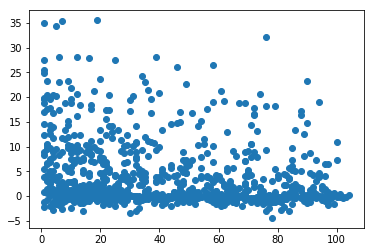

In [10]:
# Sanity checking our data by graphing always works.
# We see a handful of studs and a lot of mediocrity throughout
# But there are also clearly more success earlier in the draft.
plt.scatter(merged.Overall, merged.WAR)

In [11]:
# So let's replace games played with 0 and WAR with 0 for every player who did not play in the majors.
# For WAR, this is probably not a good practice, as a -0.5 WAR player is probably better than one who did not make the majors
# But this is probably a small enough effect and the difference in value is small enough that I won't spend much time on it.
merged['G'].fillna(0, inplace=True)
merged['WAR'].fillna(0, inplace=True)

# Next, I want a variable that is either yes or no for majors, so I can come up with a probability of reaching the majors
# It doesn't make a ton of difference how many games a player played if you already have their WAR
# And paying too much attention to games rather than WAR will underrate starting pitchers
a = np.array(merged['G'].values.tolist())
merged['MLB'] = np.where(a > 0, 1, a).tolist()

In [12]:
# I also made a time to majors variable.
merged['Minors'] = merged.debut - merged['Draft Year']

In [13]:
# This merge will come up with an average WAR, time to debut, and % chance of reaching the majors by draft position
byDpos = merged.groupby('Overall').agg({'WAR': 'mean', 'Minors': 'mean', 'MLB': 'mean'})
byDpos.head()

,WAR,Minors,MLB
Overall,,,
1,13.266667,2.117647,0.944444
2,7.066667,2.466667,0.833333
3,6.444444,1.937500,0.888889
4,5.033333,2.125000,0.888889
5,3.994444,2.307692,0.722222


Text(0, 0.5, 'WAR')

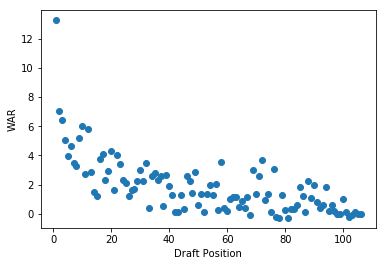

In [14]:
#Another sanity check graph. Looks reasonable
plt.scatter(byDpos.index, byDpos.WAR)
plt.xlabel('Draft Position')
plt.ylabel('WAR')

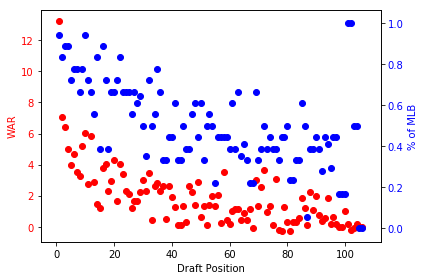

In [15]:
#A nice graph to overlay chance of MLB and average WAR by position. These should more or less line up
fig, ax1 = plt.subplots()

ax1.set_xlabel('Draft Position')
ax1.set_ylabel('WAR', color='red')
ax1.scatter(byDpos.index, byDpos.WAR, color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('% of MLB', color='blue')
ax2.scatter(byDpos.index, byDpos.MLB, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()

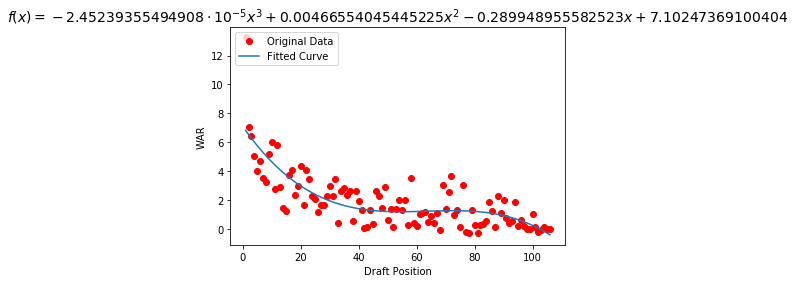

In [16]:
# Now I want to graph the mean of these probabilities, so that we can come up with a smoothed likelihood and WAR Total

# To make the whole thing simpler we will assign x & Y variables
x = byDpos.index
y = byDpos.WAR  

#Defining a function for running an exponential curve to fit
def func(x, a, b, c, d):
    return a*x**3 + b*x**2 +c*x + d

#Fit the curve to the data
popt, pcov = curve_fit(func, x, y)

# Plotting my original data
plt.plot(x, y, 'ro',label="Original Data")

# Make a pretty version of the function of draft position
xs = sym.Symbol('x')    
tex = sym.latex(func(xs,*popt)).replace('$', '')
plt.title(r'$f(x)= %s$' %(tex),fontsize=14)


# PLot the fitted curve
plt.plot(x, func(x, *popt), label="Fitted Curve")
plt.legend(loc='upper left')
plt.xlabel('Draft Position')
plt.ylabel('WAR')
plt.show()

# This graph indicates that a player drafted 80th overall is slightly more valuable than a player drafted 50th, which is obviously wrong, but it is close enough for the analysis we are performing at present. A better analysis would smooth the input data before the regession, because a higher pick is always more valuable than a lower pick in theory, even if some actual picks are not as successful in practice.

In [17]:
war17 = func(17, *popt)

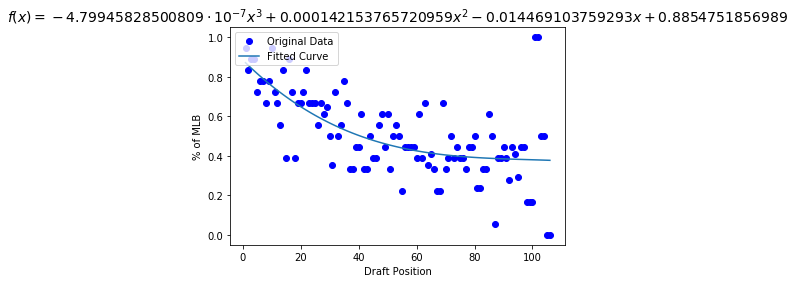

In [18]:
# Now let's do the same thing but change to the likelihood of making the majors.
# Note: we already have the WAR, which includes 0 WAR for players who did not reach the majors.
# This is more informative, rather than especialy useful

y = byDpos.MLB

popt, pcov = curve_fit(func, x, y)

# Plotting my original data
plt.plot(x, y, 'bo',label="Original Data")

# Make a pretty version of the function of draft position
xs = sym.Symbol('x')    
tex = sym.latex(func(xs,*popt)).replace('$', '')
plt.title(r'$f(x)= %s$' %(tex),fontsize=14)


# PLot the fitted curve
plt.plot(x, func(x, *popt), label="Fitted Curve")
plt.legend(loc='upper left')
plt.xlabel('Draft Position')
plt.ylabel('% of MLB')
plt.show()

In [19]:
MLB17 = func(17, *popt)

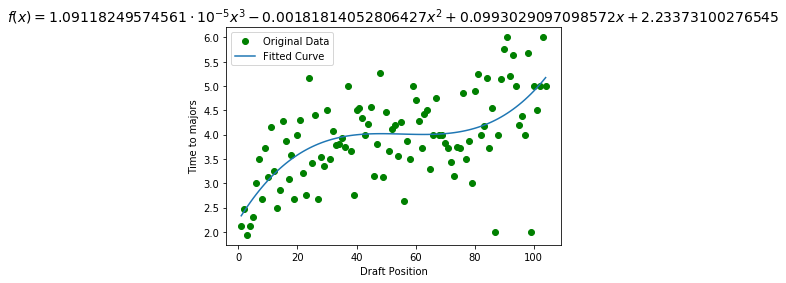

In [20]:
# Finally let's do the same thing but change to the time to reach the majors.
# This will require the exclusion of players who did not reach the majors for the so it will be time to majors, given that you make it.
minors = byDpos.dropna()
x = minors.index
y = minors.Minors

popt, pcov = curve_fit(func, x, y)

# Plotting my original data
plt.plot(x, y, 'go',label="Original Data")

# Make a pretty version of the function of draft position
xs = sym.Symbol('x')    
tex = sym.latex(func(xs,*popt)).replace('$', '')
plt.title(r'$f(x)= %s$' %(tex),fontsize=14)


# PLot the fitted curve
plt.plot(x, func(x, *popt), label="Fitted Curve")
plt.legend(loc='upper left')
plt.xlabel('Draft Position')
plt.ylabel('Time to majors')
plt.show()

In [21]:
minors17 = func(17, *popt)

In [25]:
print(f'We should expect that a player drafted 17th overall will go on to produce {round(war17,1)} WAR') 
print(f'and has a {round(MLB17 *100, 1)}% chance of reaching MLB.')
print(f'We should expect that it will take {round(minors17,1)} years for this player to reach MLB. (If he makes it at all)')

We should expect that a player drafted 17th overall will go on to produce 3.4 WAR
and has a 67.8% chance of reaching MLB.
We should expect that it will take 3.5 years for this player to reach MLB. (If he makes it at all)


In [23]:
# Based on the values we have calculated, I would use the present value of the player's expected $/WAR at a discount rate of 8%
warDollar = 9000000
discount = .08
value = round(np.pv(discount, minors17, -MLB17*warDollar),2)

# Note, this dollar figure assumes that each player will be worth all of their 6 years of control worth of WAR the year they arrive, which is obviously incorrect.
# Also, their later years are not appropriately valued, because they should be discounted further to account for rising arbitration salaries.
# However, this data is older and I would posit that teams have likely gotten better at drafting, and therefore the 17th pick in the 2020 MLB draft will produce more WAR than the similar pick in the 1980 draft and that talent will concentrate slightly higher in the draft as player evaluation has improved.
# Also, the figure I have elected comes very close to a more thorough analysis performed by Craig Edwards of FanGraphs (https://blogs.fangraphs.com/an-update-on-how-to-value-draft-picks/). As such, I am comfortable that the figure I have arrived at is reasonable.

In [24]:
print(f' Based on this analysis I would pay ${value} for the 17th pick in the 2020 draft.')

 Based on this analysis I would pay $17792644.31 for the 17th pick in the 2020 draft.
